In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from sklearn.metrics import accuracy_score



In [44]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

STATE PATH AND RESIZE IMAGES

In [45]:
X_train = []
Y_train = []
image_size = 150
labels = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)


In [46]:
X_train , Y_train = shuffle(X_train, Y_train, random_state = 101)
X_train.shape

(6400, 150, 150, 3)

In [47]:
X_train , X_test , y_train , y_test = train_test_split(X_train,Y_train, test_size=0.1 , random_state=101)

In [48]:
y_train


array(['MildDemented', 'NonDemented', 'VeryMildDemented', ...,
       'VeryMildDemented', 'NonDemented', 'NonDemented'], dtype='<U16')

COVERSION OF STATES TO INDEX

In [49]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

CONVOLUTIONAL NEURAL NETWORK

RESNET ARCHITECTURE

In [51]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained ResNet50 model
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable = False

# Create a new model
res_model = Sequential()

# Add the pre-trained ResNet50 model as the first layer
res_model.add(resnet_model)

# Add additional layers
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(4, activation='softmax'))

# Apply data augmentation
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Compile the model
res_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with data augmentation
final1 = res_model.fit(
                  X_train,y_train,  
                 epochs=10,
                  batch_size=32,
                  validation_split=0.1
)



Epoch 1/10
162/162 [==============================] - 12s 44ms/step - loss: 1.5317 - accuracy: 0.4408 - val_loss: 1.7531 - val_accuracy: 0.5260
Epoch 2/10
162/162 [==============================] - 6s 36ms/step - loss: 1.0249 - accuracy: 0.5993 - val_loss: 0.7346 - val_accuracy: 0.6927
Epoch 3/10
162/162 [==============================] - 6s 36ms/step - loss: 0.8122 - accuracy: 0.6682 - val_loss: 0.9753 - val_accuracy: 0.5799
Epoch 4/10
162/162 [==============================] - 6s 36ms/step - loss: 0.6458 - accuracy: 0.7438 - val_loss: 0.6598 - val_accuracy: 0.7274
Epoch 5/10
162/162 [==============================] - 6s 35ms/step - loss: 0.5034 - accuracy: 0.8009 - val_loss: 0.6694 - val_accuracy: 0.7153
Epoch 6/10
162/162 [==============================] - 6s 36ms/step - loss: 0.3820 - accuracy: 0.8559 - val_loss: 0.4393 - val_accuracy: 0.8455
Epoch 7/10
162/162 [==============================] - 6s 36ms/step - loss: 0.3174 - accuracy: 0.8781 - val_loss: 0.4795 - val_accuracy: 0.822

DENSENET ARCHITECTURE


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained DenseNet121 model
densenet_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in densenet_model.layers:
    layer.trainable = False

# Create a new model
ensenet_model= Sequential()

# Add the pre-trained DenseNet121 model as the first layer
ensenet_model.add(densenet_model)

# Add additional layers
ensenet_model.add(Flatten())
ensenet_model.add(Dense(256, activation='relu'))
ensenet_model.add(BatchNormalization())
ensenet_model.add(Dropout(0.5))
ensenet_model.add(Dense(256, activation='relu'))
ensenet_model.add(BatchNormalization())
ensenet_model.add(Dropout(0.5))
ensenet_model.add(Dense(4, activation='softmax'))

# # Apply data augmentation
# data_generator = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Compile the model
ensenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with data augmentation
final2 = ensenet_model.fit(
    X_train, y_train,  # Replace with your training data
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)


Epoch 1/10
162/162 [==============================] - 17s 50ms/step - loss: 1.5205 - accuracy: 0.4639 - val_loss: 9.6436 - val_accuracy: 0.0104
Epoch 2/10
162/162 [==============================] - 6s 36ms/step - loss: 1.1143 - accuracy: 0.5654 - val_loss: 0.9201 - val_accuracy: 0.6302
Epoch 3/10
162/162 [==============================] - 6s 35ms/step - loss: 0.9246 - accuracy: 0.6130 - val_loss: 0.7524 - val_accuracy: 0.6788
Epoch 4/10
162/162 [==============================] - 6s 36ms/step - loss: 0.8135 - accuracy: 0.6555 - val_loss: 0.8800 - val_accuracy: 0.5938
Epoch 5/10
162/162 [==============================] - 6s 36ms/step - loss: 0.7498 - accuracy: 0.6848 - val_loss: 0.7188 - val_accuracy: 0.6858
Epoch 6/10
162/162 [==============================] - 6s 35ms/step - loss: 0.6851 - accuracy: 0.7114 - val_loss: 0.7347 - val_accuracy: 0.6719
Epoch 7/10
162/162 [==============================] - 6s 36ms/step - loss: 0.6212 - accuracy: 0.7421 - val_loss: 0.5671 - val_accuracy: 0.756

MOBILENET ARCHITECTURE

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained MobileNetV2 model
mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in mobilenet_model.layers:
    layer.trainable = False

# Create a new model
e_model = Sequential()

# Add the pre-trained MobileNetV2 model as the first layer
e_model.add(mobilenet_model)

# Add additional layers
e_model.add(Flatten())
e_model.add(Dense(256, activation='relu'))
e_model.add(BatchNormalization())
e_model.add(Dropout(0.5))
e_model.add(Dense(256, activation='relu'))
e_model.add(BatchNormalization())
e_model.add(Dropout(0.5))
e_model.add(Dense(4, activation='softmax'))

# Compile the model
e_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with data augmentation
final_mob = e_model.fit(
    X_train, y_train,  # Replace with your training data
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)


Epoch 1/15
162/162 [==============================] - 8s 25ms/step - loss: 1.5722 - accuracy: 0.4431 - val_loss: 1.2059 - val_accuracy: 0.4826
Epoch 2/15
162/162 [==============================] - 3s 18ms/step - loss: 1.1357 - accuracy: 0.5305 - val_loss: 0.8747 - val_accuracy: 0.6250
Epoch 3/15
162/162 [==============================] - 3s 18ms/step - loss: 0.9939 - accuracy: 0.5604 - val_loss: 0.8509 - val_accuracy: 0.6198
Epoch 4/15
162/162 [==============================] - 3s 17ms/step - loss: 0.8826 - accuracy: 0.6007 - val_loss: 0.8622 - val_accuracy: 0.5972
Epoch 5/15
162/162 [==============================] - 3s 18ms/step - loss: 0.8190 - accuracy: 0.6345 - val_loss: 0.8223 - val_accuracy: 0.6215
Epoch 6/15
162/162 [==============================] - 3s 17ms/step - loss: 0.7754 - accuracy: 0.6593 - val_loss: 0.8887 - val_accuracy: 0.5868
Epoch 7/15
162/162 [==============================] - 3s 19ms/step - loss: 0.7245 - accuracy: 0.6831 - val_loss: 0.8304 - val_accuracy: 0.6267

In [54]:
from tensorflow.keras.models import Model

# Get the output tensors of both models
resnet_output = res_model.layers[-1].output
densenet_output = ensenet_model.layers[-1].output
mobilenet_output = e_model.layers[-1].output

# Average the predictions from both models
ensemble_output = tf.keras.layers.average([resnet_output, densenet_output, mobilenet_output])

# Create the ensemble model
ensemble_model = Model(inputs=[res_model.input, ensenet_model.input, e_model.input], outputs=ensemble_output)


ENSEMBLE MODEL PERFORMANCE

In [55]:
# Assuming you have test data: X_test and y_test

# Compile the ensemble model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the ensemble model on test data
_, accuracy = ensemble_model.evaluate([X_test, X_test, X_test], y_test)  # Assuming you have X_test and y_test

print("Ensemble Model Accuracy:", accuracy)


20/20 [==============================] - 8s 73ms/step - loss: 0.4375 - accuracy: 0.8813
Ensemble Model Accuracy: 0.8812500238418579


CONFUSION MATRIX

In [56]:

from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have test data: X_test and y_test

# Predictions of individual models
resnet_predictions = res_model.predict(X_test)
densenet_predictions = ensenet_model.predict(X_test)
mobilenet_predictions = e_model.predict(X_test)

# Ensemble predictions
ensemble_predictions = ensemble_model.predict([X_test, X_test, X_test])

# Convert predictions to class labels
resnet_labels = np.argmax(resnet_predictions, axis=1)
densenet_labels = np.argmax(densenet_predictions, axis=1)
mobilenet_labels = np.argmax(mobilenet_predictions, axis=1)
ensemble_labels = np.argmax(ensemble_predictions, axis=1)

# Convert true labels to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Confusion matrix for individual models
resnet_cm = confusion_matrix(y_true_labels, resnet_labels)
densenet_cm = confusion_matrix(y_true_labels, densenet_labels)
mobilenet_cm = confusion_matrix(y_true_labels, mobilenet_labels)

# Confusion matrix for ensemble model
ensemble_cm = confusion_matrix(y_true_labels, ensemble_labels)

# Classification report for individual models
print("ResNet Classification Report:")
print(classification_report(y_true_labels, resnet_labels, target_names=labels))

print("DenseNet Classification Report:")
print(classification_report(y_true_labels, densenet_labels, target_names=labels))

print("MobileNet Classification Report:")
print(classification_report(y_true_labels, mobilenet_labels, target_names=labels))

# Classification report for ensemble model
print("Ensemble Model Classification Report:")
print(classification_report(y_true_labels, ensemble_labels, target_names=labels))


20/20 [==============================] - 5s 70ms/step
ResNet Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.88      0.73      0.80        94
ModerateDemented       1.00      1.00      1.00         7
     NonDemented       0.75      0.99      0.85       319
VeryMildDemented       0.95      0.57      0.71       220

        accuracy                           0.81       640
       macro avg       0.90      0.82      0.84       640
    weighted avg       0.84      0.81      0.80       640

DenseNet Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.58      0.88      0.70        94
ModerateDemented       0.00      0.00      0.00         7
     NonDemented       0.89      0.69      0.78       319
VeryMildDemented       0.67      0.76      0.71       220

        accuracy                           0.74       640
       macro avg       0.54      0.58      0.55       640
    weigh

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

TRAINING ENSEMBLE MODEL

Epoch 1/5
179/179 [==============================] - 31s 134ms/step - loss: 0.3574 - accuracy: 0.8995 - val_loss: 0.6386 - val_accuracy: 0.7069
Epoch 2/5
179/179 [==============================] - 14s 77ms/step - loss: 0.3624 - accuracy: 0.8964 - val_loss: 0.6386 - val_accuracy: 0.7069
Epoch 3/5
179/179 [==============================] - 14s 76ms/step - loss: 0.3609 - accuracy: 0.8941 - val_loss: 0.6386 - val_accuracy: 0.7069
Epoch 4/5
179/179 [==============================] - 14s 78ms/step - loss: 0.3543 - accuracy: 0.8976 - val_loss: 0.6386 - val_accuracy: 0.7069
Epoch 5/5
179/179 [==============================] - 14s 76ms/step - loss: 0.3683 - accuracy: 0.8930 - val_loss: 0.6386 - val_accuracy: 0.7069


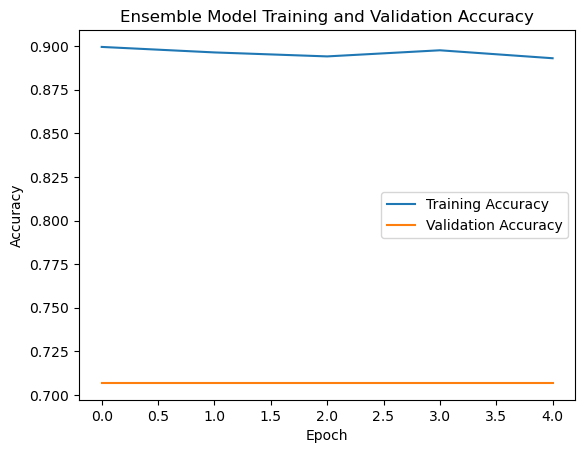

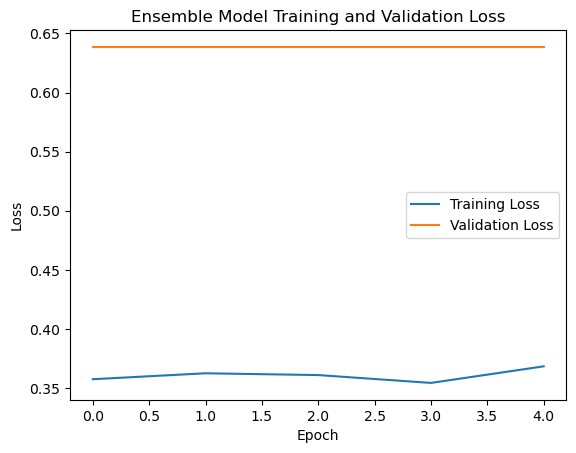

In [72]:
import matplotlib.pyplot as plt

# Train the ensemble model
history = ensemble_model.fit(
    [X_train, X_train, X_train], y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Ensemble Model Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Ensemble Model Training and Validation Loss')
plt.legend()
plt.show()


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

DENSENET TRAINING-VALIDATION GRAPH

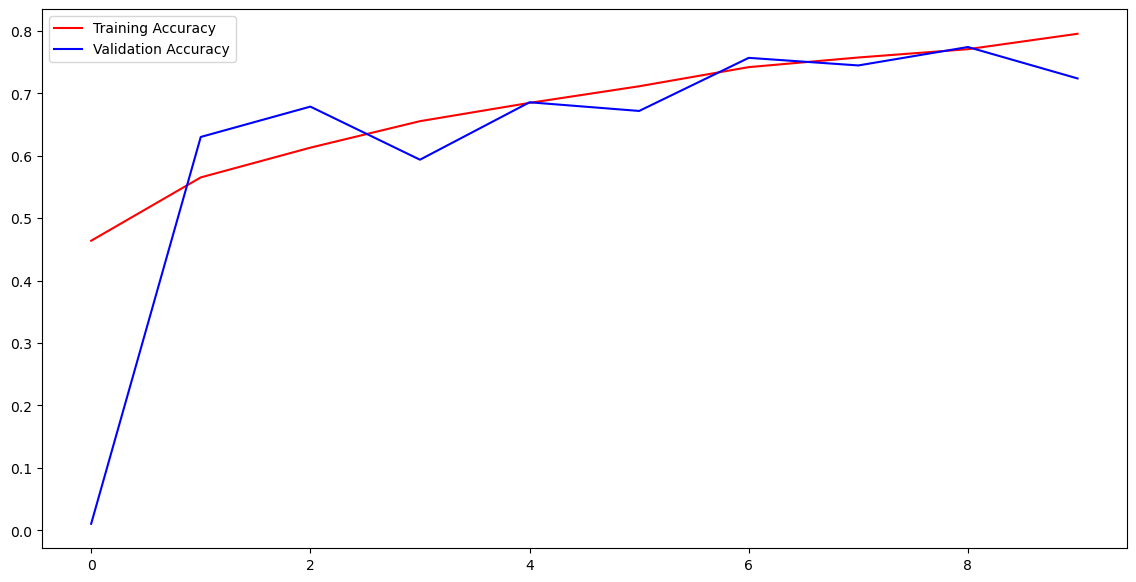

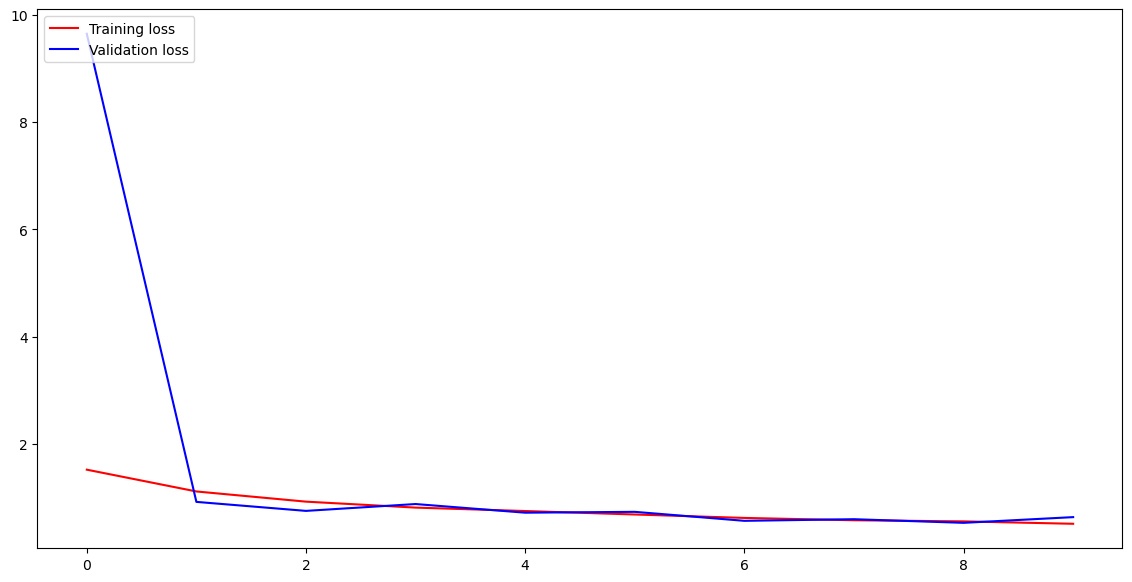

In [59]:
acc = final2.history['accuracy']
val_acc = final2.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()
loss = final2.history['loss']
val_loss = final2.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

MOBILENET TRAINING-VALIDATION GRAPH

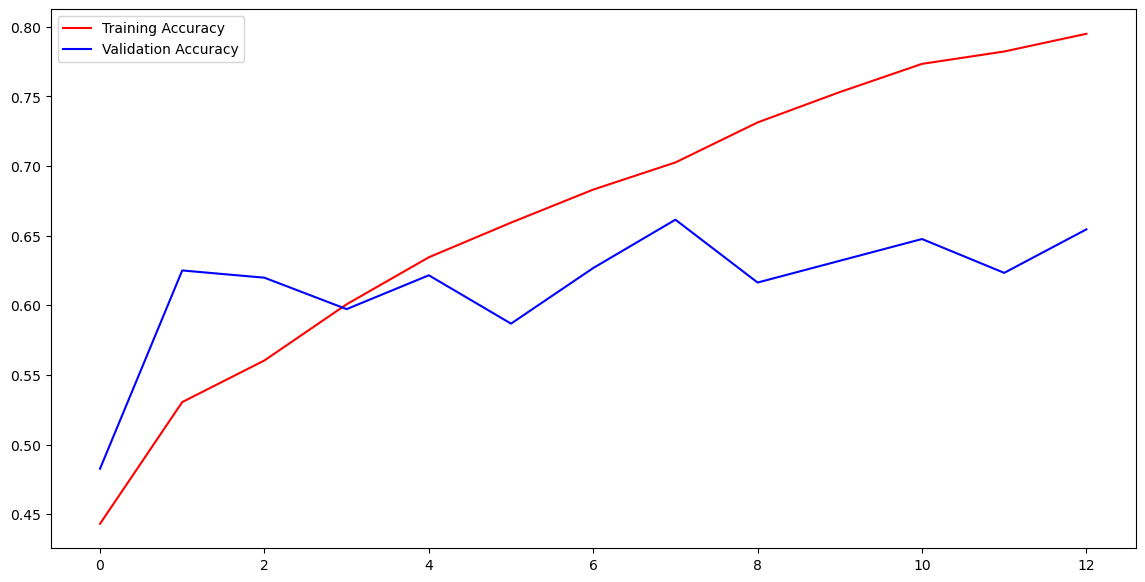

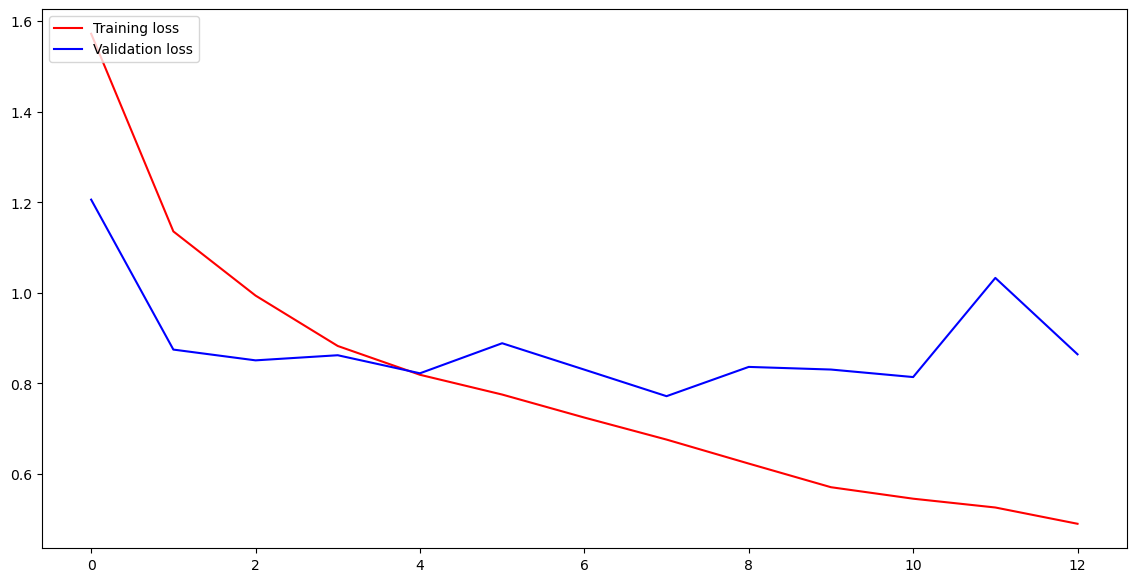

In [60]:
acc = final_mob.history['accuracy']
val_acc = final_mob.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()
loss = final_mob.history['loss']
val_loss = final_mob.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

RESNET TRAINING-VALIDATION GRAPH

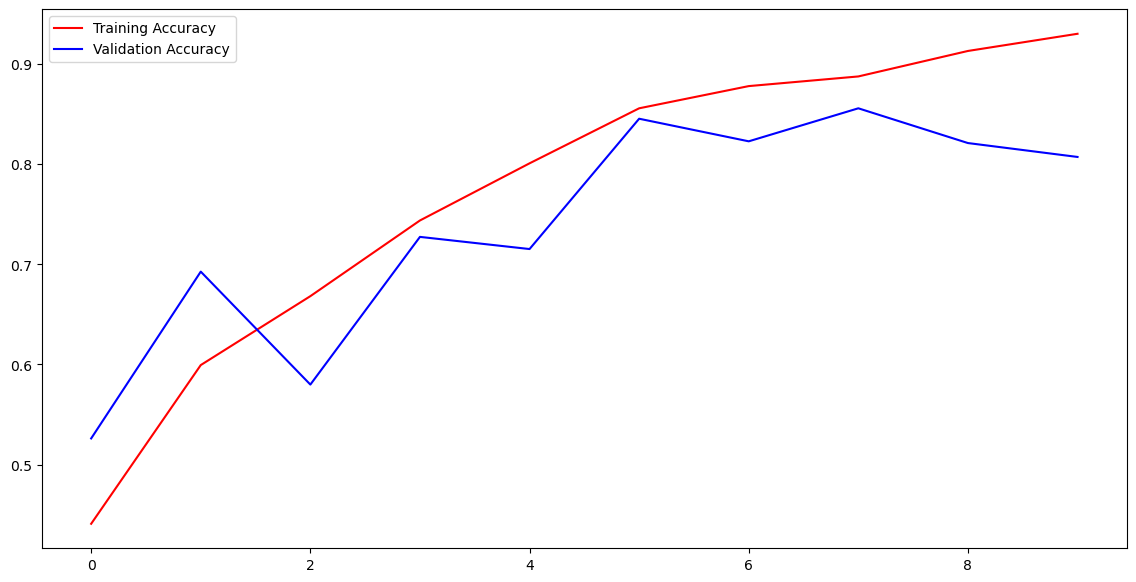

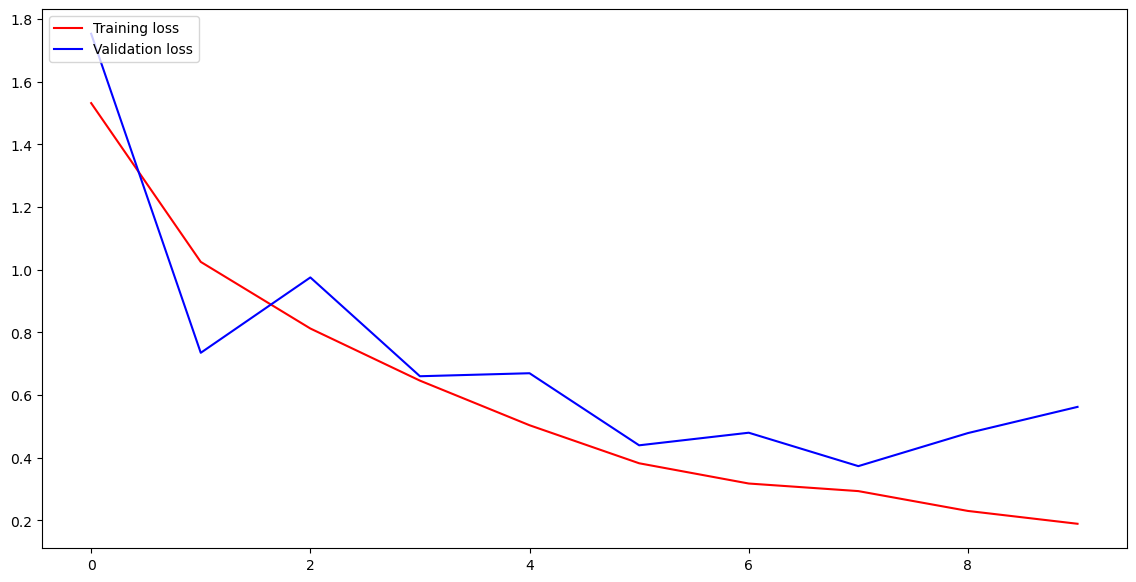

In [61]:
acc = final1.history['accuracy']
val_acc = final1.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()
loss = final1.history['loss']
val_loss = final1.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

IMPORT IMAGE

In [62]:
img = cv2.imread('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [63]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

PREDICTION

1/1 [==============================] - 6s 6s/step


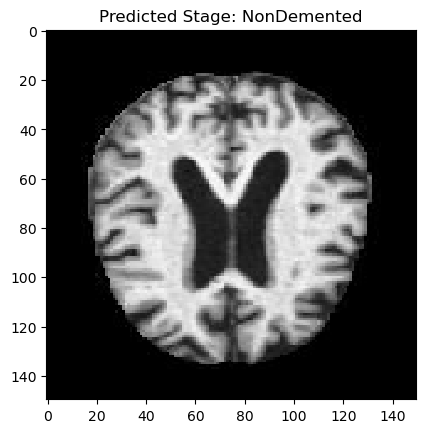

In [74]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)

# Expand the dimensions to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array = img_array / 255.0

# Make the prediction
prediction = ensemble_model.predict([img_array, img_array, img_array])

# Get the predicted class label
labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
predicted_class = labels[np.argmax(prediction)]

# Display the image
plt.imshow(img, interpolation='nearest')
plt.title("Predicted Stage: " + predicted_class)
plt.show()
